In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import math

In [3]:
s = gpd.read_file('data/streets_full.json')

In [4]:
s

,street_edge_id,way_type,geometry
0,31,tertiary,"LINESTRING (-122.32015 47.67952, -122.32065 47..."
1,34,tertiary,"LINESTRING (-122.31371 47.65159, -122.31372 47..."
2,83,primary,"LINESTRING (-122.28354 47.66421, -122.28354 47..."
3,103,primary,"LINESTRING (-122.26862 47.67178, -122.26866 47..."
4,123,secondary,"LINESTRING (-122.31946 47.65450, -122.31930 47..."
...,...,...,...
27405,26714,residential,"LINESTRING (-122.34139 47.71486, -122.34140 47..."
27406,26715,residential,"LINESTRING (-122.34140 47.71516, -122.34139 47..."
27407,26716,residential,"LINESTRING (-122.33948 47.71595, -122.33976 47..."
27408,26717,residential,"LINESTRING (-122.34139 47.71556, -122.34033 47..."


In [5]:
# Extract start and end coordinates of each linestring
first_coord = s["geometry"].apply(lambda g: g.coords[0])
last_coord = s["geometry"].apply(lambda g: g.coords[-1])

# Add start and end as columns to the s
s["start_coord"] = first_coord
s["end_coord"] = last_coord

In [6]:
p0 = s[['start_coord', 'way_type']]
p1 = s[['end_coord','way_type']]
p0 = p0.rename(columns={'start_coord':'coord'})
p1 = p1.rename(columns={'end_coord':'coord'})
result = pd.concat([p0,p1])

In [8]:
result

,coord,way_type
0,"(-122.3201532, 47.6795182)",tertiary
1,"(-122.3137088, 47.65159)",tertiary
2,"(-122.28354180299418, 47.66421153296299)",primary
3,"(-122.2686183, 47.6717807)",primary
4,"(-122.31946, 47.6545022)",secondary
...,...,...
27405,"(-122.341404, 47.7151635)",residential
27406,"(-122.341391, 47.7148568)",residential
27407,"(-122.3397583, 47.7157525)",residential
27408,"(-122.3403348, 47.715334)",residential


In [9]:
#convert points into gpd
points = result.apply(lambda row: Point(row), axis=1)
#fix coordinate system
p_geo = gpd.GeoDataFrame(result, geometry=points)
p_geo.crs = {'init': 'epsg:4326'}
p_geo = p_geo.to_crs("EPSG:2285")

In [10]:
#seperate by way_type
p_primary = p_geo[p_geo['way_type'] == 'primary']
p_secondary = p_geo[p_geo['way_type'] == 'secondary']
p_tertiary = p_geo[p_geo['way_type'] == 'tertiary']
p_residential = p_geo[p_geo['way_type'] == 'residential']

In [11]:
#set the radius for different road types
primary = 100
secondary = 80
tertiary = 60
residential = 40

In [12]:
r_primary = p_primary.buffer(primary)
r_secondary = p_secondary.buffer(secondary)
r_tertiary = p_tertiary.buffer(tertiary)
r_residential = p_residential.buffer(residential)

In [13]:
r_primary = gpd.GeoDataFrame(geometry=gpd.GeoSeries(r_primary))
r_secondary = gpd.GeoDataFrame(geometry=gpd.GeoSeries(r_secondary))
r_tertiary = gpd.GeoDataFrame(geometry=gpd.GeoSeries(r_tertiary))
r_residential = gpd.GeoDataFrame(geometry=gpd.GeoSeries(r_residential))

In [14]:
r_primary['way_type'] = 'primary'
r_secondary['way_type'] = 'secondary'
r_tertiary['way_type'] = 'tertiary'
r_residential['way_type'] = 'residential'

In [15]:
#concatenate all buffers
r = pd.concat([r_primary, r_secondary, r_tertiary, r_residential])

In [17]:
r.explore(column='way_type', tiles='cartodb_positron')

### EPSG:2285 
NAD 83 / Washington North (ftUS) https://epsg.io/2285 

In [11]:
labels = gpd.read_file('data/seattle_labels.geojson')

In [12]:
labels 

,label_id,gsv_panorama_id,zoom,heading,pitch,photographer_heading,photographer_pitch,label_type,severity,user_id,lat,lng,geometry
0,85053,3sAn6u8bQPVW3hTDfNUP1w,1,107.750000,-15.625000,270.675171,0.168884,CurbRamp,1.0,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.618618,-122.333054,POINT (-122.33305 47.61862)
1,85004,CpU83mS7vz17EnE02JGOkg,1,41.750000,-10.375000,129.873657,0.026001,CurbRamp,1.0,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.618134,-122.340515,POINT (-122.34052 47.61813)
2,85024,RDV4HddwNqwfBZndZRqqkA,1,100.437500,-12.625000,128.847916,0.042198,CurbRamp,1.0,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.615307,-122.337608,POINT (-122.33761 47.61531)
3,85025,NpkOF1LfE024Ks0XIhCttw,1,136.062500,-11.500000,350.971405,1.353600,CurbRamp,1.0,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.615089,-122.337662,POINT (-122.33766 47.61509)
4,85034,-l9SjmKbZmUfr3JV3PuTVg,1,180.312500,-15.562500,171.933517,-0.698708,CurbRamp,1.0,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.614845,-122.337921,POINT (-122.33792 47.61485)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195538,96388,Ek8nn67kKNgCFjZkKf9ISA,2,348.645081,-3.973214,318.706665,0.226311,NoSidewalk,3.0,f2a1a9cc-466f-4ee2-83d4-2d8ff46a31fe,47.658714,-122.389786,POINT (-122.38979 47.65871)
195539,122316,6U9DDI4UppbHDTyp8_J3JA,1,3.171875,-32.000000,186.167953,0.891960,NoCurbRamp,5.0,7d65ec0f-4ba8-4895-abfb-eb75fab3104e,47.644711,-122.387703,POINT (-122.38770 47.64471)
195540,122337,lydaO-3xUm3YPy2sNPyPoQ,1,288.500000,-20.250000,181.292786,5.152237,SurfaceProblem,2.0,7d65ec0f-4ba8-4895-abfb-eb75fab3104e,47.641743,-122.387810,POINT (-122.38781 47.64174)
195541,122341,ubr500pdt0vImqg71_dHsQ,1,198.312500,-23.562500,180.803787,3.150978,CurbRamp,1.0,7d65ec0f-4ba8-4895-abfb-eb75fab3104e,47.641102,-122.387764,POINT (-122.38776 47.64110)


In [13]:
curb = labels.loc[(labels['label_type']=='CurbRamp')]

<AxesSubplot: >

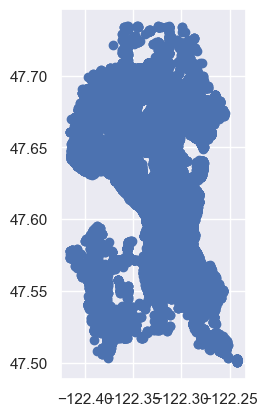

In [14]:
curb.plot()

In [15]:
#change coordinate system
curb = curb.to_crs("EPSG:2285")

In [21]:
curb_tp = curb.sjoin(r2, op="within", how="inner")

In [22]:
id_list= curb_tp['label_id'].unique().tolist()
curb_fp = curb[~curb['label_id'].isin(id_list)]

In [23]:
curb_fp.explore()

In [94]:
# save the data as a geojson file
curb_fp.to_file('data/curb_fp.geojson', driver='GeoJSON')

In [2]:
# read the geojson file
curb_fp = gpd.read_file('data/curb_fp.geojson')

In [5]:
# save curb_fp as a csv file, index=False to avoid saving the index
curb_fp.to_csv('data/curb_fp.csv', index=False)